# Pipelines & grid search to find "best" model
- Note: I'm skipping some of the exploratory steps in this notebook to focus instead on the pipelines & grid search check out the [EDA notebook](EDA.ipynb) for process on cleaning steps, initial trial & error on stop words, etc.

In [82]:
import pickle
import pprint
import re

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN

import modeling_reporting

## Read & clean data
- cleaning:
    - fill any missing `selftext` with the `title` from that post
    - remove the handful rows that were extracted oddly

In [2]:
posts = pd.read_csv("data/raw_posts.csv")

# copying "title" text into the "selftext" column where "selftext" is null
posts["selftext"] = posts["selftext"].fillna(posts["title"])

In [3]:
posts.isna().sum()

title          1
selftext       0
subreddit      3
created_utc    3
name           3
type           6
dtype: int64

In [4]:
# I know from the EDA notebook that there are a few rows with what looked like UTC timestamps in the "subreddit" field
#  filtering those out & that should get rid of the nulls in columns other than "selfext"
posts = posts.loc[posts["subreddit"].isin(["AskScienceFiction", "space", "askscience"])]
posts["subreddit"].value_counts(normalize=True)

subreddit
AskScienceFiction    0.414044
space                0.331027
askscience           0.254929
Name: proportion, dtype: float64

In [5]:
posts.isna().sum()

title          0
selftext       0
subreddit      0
created_utc    0
name           0
type           0
dtype: int64

## Set X & y and split data
- Setting "AskScienceFiction" as my positive class (41.4% of the data)
- "askscience" and "space" combined = my negative class (58.6% of the data)
- baseline is 58.6%

In [6]:
posts["target"] = np.where(posts["subreddit"] == "AskScienceFiction", 1, 0)
X = posts["selftext"]
y = posts["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

----
## Build some pipelines

In [7]:
pipe_params = {
    "cvec__stop_words": [None, modeling_reporting.custom_stops()],
    "cvec__max_features": [None, 250, 300],
    "cvec__min_df": [1, 0.01, 0.05],
    "cvec__max_df": [1.0, 0.98, 0.95, 0.9],
    "cvec__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__stop_words": [None, modeling_reporting.custom_stops()],
    "tfidf__max_features": [None, 250, 300],
    "tfidf__min_df": [1, 0.01, 0.05],
    "tfidf__max_df": [1.0, 0.98, 0.95, 0.9],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "lr__solver": ["lbfgs", "liblinear"],
    "lr__C": [1.0, 0.1, 10],
    "multi__alpha": [1.0, 0.5],
    "rfc__n_estimators": [100, 50, 150],
    "rfc__max_depth": [None, 5, 10],
    "rfc__min_samples_split": [2, 5, 7],
    "rfc__min_samples_leaf": [1, 2, 3],
    "rfc__bootstrap": [True, False]
}

In [8]:
# setting up these lists of tuples to pass to my function that generates the GridSearchCV object
cvec_pipe_1 = [("cvec", CountVectorizer()), ("lr", LogisticRegression(max_iter=1000))]
cvec_pipe_2 = [("cvec", CountVectorizer()), ("multi", MultinomialNB())]
cvec_pipe_3 = [("cvec", CountVectorizer()), ("rfc", RandomForestClassifier())]
tfidf_pipe_4 = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression(max_iter=1000))]
tfidf_pipe_5 = [("tfidf", TfidfVectorizer()), ("multi", MultinomialNB())]
tfidf_pipe_6 = [("tfidf", TfidfVectorizer()), ("rfc", RandomForestClassifier())]

## Fit or fetch models
- in this section, I've kept the cells where I initially created & fit the grid search but they're commented out
- just below each one is the call I used later to pull the pickled pipeline, fit it again & get the model ready for further analysis
- the naming convention for all of the models is `gs_{pipe number}` so, for example, wherever there's `{something}_2`, that thing will be connected to the second pipeline, whether is the pipeline itself, the grid search result of the pipeline, the scores for that pipeline, etc.

#### CountVectorizer & LogisticRegression model

In [ ]:
# use `train_save_best_model` with a pipeilne to fit best model & save as pickle
# gs_1 = modeling_reporting.train_save_best_model(cvec_pipe_1, pipe_params, X_train, y_train, "models/gs_1_model.pkl")

In [9]:
# use `fetch_fitted_pipeline` to fetch previously-fitted pipeline
gs_1 = modeling_reporting.fetch_fitted_pipeline("models/gs_1_model.pkl")
gs_1.fit(X_train, y_train)
print(f"train score: {gs_1.score(X_train, y_train)}; test score: {gs_1.score(X_test, y_test)}")

train score: 1.0; test score: 0.8963730569948186


#### CountVectorizer & MultinomialNB model

In [24]:
# gs_2 = modeling_reporting.train_save_best_model(cvec_pipe_2, pipe_params, X_train, y_train, "models/gs_2_model.pkl")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
saved model to models/gs_2_model.pkl


In [10]:
gs_2 = modeling_reporting.fetch_fitted_pipeline("models/gs_2_model.pkl")
gs_2.fit(X_train, y_train)
print(f"train score: {gs_2.score(X_train, y_train)}; test score: {gs_2.score(X_test, y_test)}")

train score: 0.9783737024221453; test score: 0.8998272884283247


#### CountVectorizer & RandomForestClassifier

In [ ]:
# gs_3 = modeling_reporting.train_save_best_model(cvec_pipe_3, pipe_params, X_train, y_train, "models/gs_3_model.pkl")

In [11]:
gs_3 = modeling_reporting.fetch_fitted_pipeline("models/gs_3_model.pkl")
gs_3.fit(X_train, y_train)
print(f"train score: {gs_3.score(X_train, y_train)}; test score: {gs_3.score(X_test, y_test)}")

train score: 1.0; test score: 0.8739205526770294


#### TfidfVectorizer & LogisticRegression model

In [ ]:
# gs_4 = modeling_reporting.train_save_best_model(tfidf_pipe_4, pipe_params, X_train, y_train, "models/gs_4_model.pkl")

In [12]:
gs_4 = modeling_reporting.fetch_fitted_pipeline("models/gs_4_model.pkl")
gs_4.fit(X_train, y_train)
print(f"train score: {gs_4.score(X_train, y_train)}; test score: {gs_4.score(X_test, y_test)}")

train score: 1.0; test score: 0.9032815198618307


#### TfidfVectorizer & MultinomialNB model

In [28]:
# gs_5 = modeling_reporting.train_save_best_model(tfidf_pipe_5, pipe_params, X_train, y_train, "models/gs_5_model.pkl")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
saved model to models/gs_5_model.pkl


In [13]:
gs_5 = modeling_reporting.fetch_fitted_pipeline("models/gs_5_model.pkl")
gs_5.fit(X_train, y_train)
print(f"train score: {gs_5.score(X_train, y_train)}; test score: {gs_5.score(X_test, y_test)}")

train score: 0.9870242214532872; test score: 0.9119170984455959


#### TfidfVectorizer & RandomForestClassifier

In [ ]:
# gs_6 = modeling_reporting.train_save_best_model(tfidf_pipe_6, pipe_params, X_train, y_train, "models/gs_6_model.pkl")

In [14]:
gs_6 = modeling_reporting.fetch_fitted_pipeline("models/gs_6_model.pkl")
gs_6.fit(X_train, y_train)
print(f"train score: {gs_6.score(X_train, y_train)}; test score: {gs_6.score(X_test, y_test)}")

train score: 1.0; test score: 0.8635578583765112


### Collect metrics

In [15]:
scores_df = pd.DataFrame()
model_and_label = [(gs_1, "CountVect & LogReg"), (gs_2, "CountVect & MultiNB"), (gs_3, "CountVect & RandForest"),
                   (gs_4, "TfidfVect & LogReg"), (gs_5, "TfidfVect & MultiNB"), (gs_6, "TfidfVect & RandForest")]
for model in model_and_label:
    scores_df = modeling_reporting.store_metrics(X_test, y_test, scores_df, model[0], model[1])
scores_df.head()

,model_name,score_type,score
0,CountVect & LogReg,balanced_accuracy,0.886560
1,CountVect & LogReg,f1_score,0.868996
2,CountVect & LogReg,recall,0.829167
3,CountVect & LogReg,precision,0.912844
0,CountVect & MultiNB,balanced_accuracy,0.900461


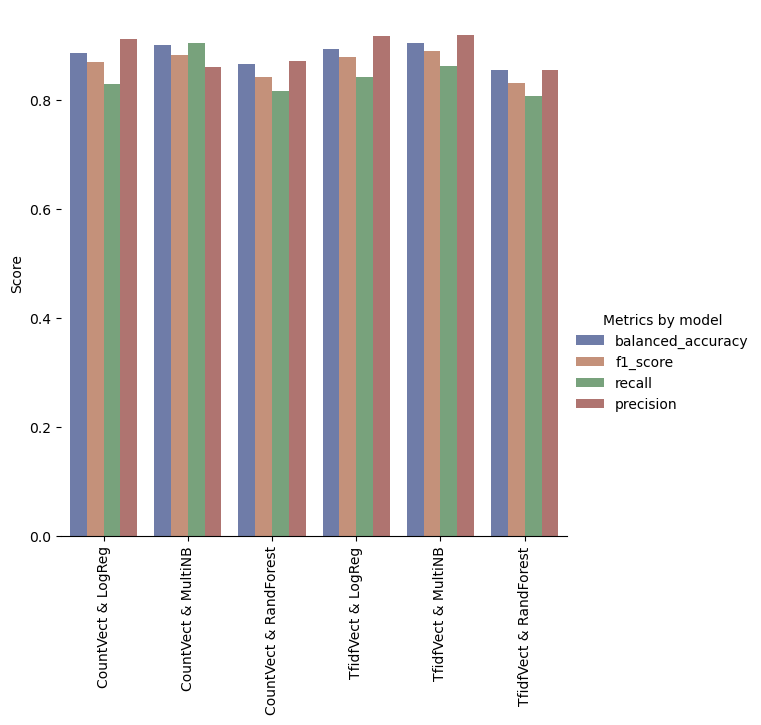

In [16]:
# thanks to Sonyah for pointing me in the right direction on this chart

bars = sns.catplot(
    data=scores_df, kind="bar",
    x="model_name", y="score", hue="score_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("", "Score")
plt.xticks(rotation=90)
bars.legend.set_title("Metrics by model")

### Look at `best_params_`

In [17]:
params_dict = {}
all_params = modeling_reporting.store_params(gs_1, pipe_params, "CountVect & LogReg", params_dict)
all_params = modeling_reporting.store_params(gs_2, pipe_params, "CountVect & MultiNB", params_dict)
all_params = modeling_reporting.store_params(gs_3, pipe_params, "CountVect & RandForest", params_dict)
all_params = modeling_reporting.store_params(gs_4, pipe_params, "TfidfVect & LogReg", params_dict)
all_params = modeling_reporting.store_params(gs_5, pipe_params, "TfidfVect & MultiNB", params_dict)
all_params = modeling_reporting.store_params(gs_6, pipe_params, "TfidfVect & RandForest", params_dict)

In [18]:
pp = pprint.PrettyPrinter()
pp.pprint(all_params)

{'CountVect & LogReg': {'cvec__max_df': 1.0,
                        'cvec__max_features': None,
                        'cvec__min_df': 1,
                        'cvec__ngram_range': (1, 1),
                        'cvec__stop_words': None,
                        'lr__C': 10,
                        'lr__solver': 'lbfgs'},
 'CountVect & MultiNB': {'cvec__max_df': 1.0,
                         'cvec__max_features': None,
                         'cvec__min_df': 1,
                         'cvec__ngram_range': (1, 1),
                         'cvec__stop_words': None,
                         'multi__alpha': 1.0},
 'CountVect & RandForest': {'cvec__max_df': 0.9,
                            'cvec__max_features': None,
                            'cvec__min_df': 1,
                            'cvec__ngram_range': (1, 1),
                            'cvec__stop_words': None,
                            'rfc__bootstrap': False,
                            'rfc__max_depth': None,
         

#### TfidfVectorizer, ADASYN oversampler, LogisticRegression model

In [ ]:
# adasyn_pipe_7 = make_pipeline(TfidfVectorizer(), ADASYN(random_state=34), LogisticRegression(max_iter=1000))
# adasyn_pipe = {
#     "adasyn__n_neighbors": [3, 5, 7],
#     "tfidfvectorizer__stop_words": [None, modeling_reporting.custom_stops()],
#     "tfidfvectorizer__max_features": [None, 250, 300],
#     "tfidfvectorizer__min_df": [1, 0.01, 0.05],
#     "tfidfvectorizer__max_df": [1.0, 0.98, 0.95, 0.9],
#     "tfidfvectorizer__ngram_range": [(1,1), (1,2), (1,3)],
#     "logisticregression__solver": ["lbfgs", "liblinear"],
#     "logisticregression__C": [1.0, 0.1, 10]
#     }

# gs_7 = GridSearchCV(adasyn_pipe_7, adasyn_pipe, n_jobs=-1, scoring="balanced_accuracy")
# gs_7.fit(X_train, y_train)

# with open("models/gs_7_model.pkl", "wb") as f:
#     pickle.dump(gs_7.best_estimator_, f)

In [19]:
gs_7 = modeling_reporting.fetch_fitted_pipeline("models/gs_7_model.pkl")
gs_7.fit(X_train, y_train)
print(f"train score: {gs_7.score(X_train, y_train)}; test score: {gs_7.score(X_test, y_test)}")

train score: 0.9991349480968859; test score: 0.9015544041450777


In [20]:
scores_df = modeling_reporting.store_metrics(X_test, y_test, scores_df, gs_7, "TfidfVect, ADASYN & LogReg")
scores_df.tail()

,model_name,score_type,score
3,TfidfVect & RandForest,precision,0.854626
0,"TfidfVect, ADASYN & LogReg",balanced_accuracy,0.897069
1,"TfidfVect, ADASYN & LogReg",f1_score,0.880000
2,"TfidfVect, ADASYN & LogReg",recall,0.870833
3,"TfidfVect, ADASYN & LogReg",precision,0.889362


In [23]:
# adasyn_pipe_8 = make_pipeline(TfidfVectorizer(), ADASYN(random_state=34), MultinomialNB())
# adasyn_8_params = {
#     "adasyn__n_neighbors": [3, 5, 7],
#     "tfidfvectorizer__stop_words": [None, modeling_reporting.custom_stops()],
#     "tfidfvectorizer__max_features": [None, 250, 300],
#     "tfidfvectorizer__min_df": [1, 0.01, 0.05],
#     "tfidfvectorizer__max_df": [1.0, 0.98, 0.95, 0.9],
#     "tfidfvectorizer__ngram_range": [(1,1), (1,2), (1,3)],
#     "multinomialnb__alpha": [1.0, 0.5]
#     }

# gs_8 = GridSearchCV(adasyn_pipe_8, adasyn_8_params, n_jobs=-1, scoring="balanced_accuracy", verbose=1)
# gs_8.fit(X_train, y_train)

# with open("models/gs_8_model.pkl", "wb") as f:
#     pickle.dump(gs_8.best_estimator_, f)

# print(f"adasyn score on training data: {gs_8.score(X_train, y_train)}; test data: {gs_8.score(X_test, y_test)}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/heathercait/anaconda3/envs/ga-lessons/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/heathercait/anaconda3/envs/ga-lessons/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/heathercait/anaconda3/envs/ga-lessons/lib/python3.11/site-packages/imblearn/utils/fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/h

adasyn score on training data: 0.9845474891241481; test data: 0.8841127381514722


In [21]:
gs_8 = modeling_reporting.fetch_fitted_pipeline("models/gs_8_model.pkl")
gs_8.fit(X_train, y_train)
print(f"train score: {gs_8.score(X_train, y_train)}; test score: {gs_8.score(X_test, y_test)}")

train score: 0.9788062283737025; test score: 0.8911917098445595


In [22]:
scores_df = modeling_reporting.store_metrics(X_test, y_test, scores_df, gs_8, "TfidfVect, ADASYN & MultiNB")
scores_df.tail()

,model_name,score_type,score
3,"TfidfVect, ADASYN & LogReg",precision,0.889362
0,"TfidfVect, ADASYN & MultiNB",balanced_accuracy,0.899779
1,"TfidfVect, ADASYN & MultiNB",f1_score,0.878613
2,"TfidfVect, ADASYN & MultiNB",recall,0.950000
3,"TfidfVect, ADASYN & MultiNB",precision,0.817204


In [23]:
tfidf_vect = TfidfVectorizer()  # bests scores in GridSearch used defaults so I'm sticking with that
X_train_vect = tfidf_vect.fit_transform(X_train)
X_test_vect = tfidf_vect.transform(X_test)

gs_9 = GaussianNB()
gs_9.fit(X_train_vect.toarray(), y_train)

preds = gs_9.predict(X_test_vect.toarray())
print(f"GaussinaNB balanced accuracy: {balanced_accuracy_score(y_test, preds)}")

GaussinaNB balanced accuracy: 0.8551622418879057


In [24]:
scores_df = modeling_reporting.store_metrics(X_test_vect.toarray(), y_test, scores_df, gs_9, "TfidfVect & GaussianNB")

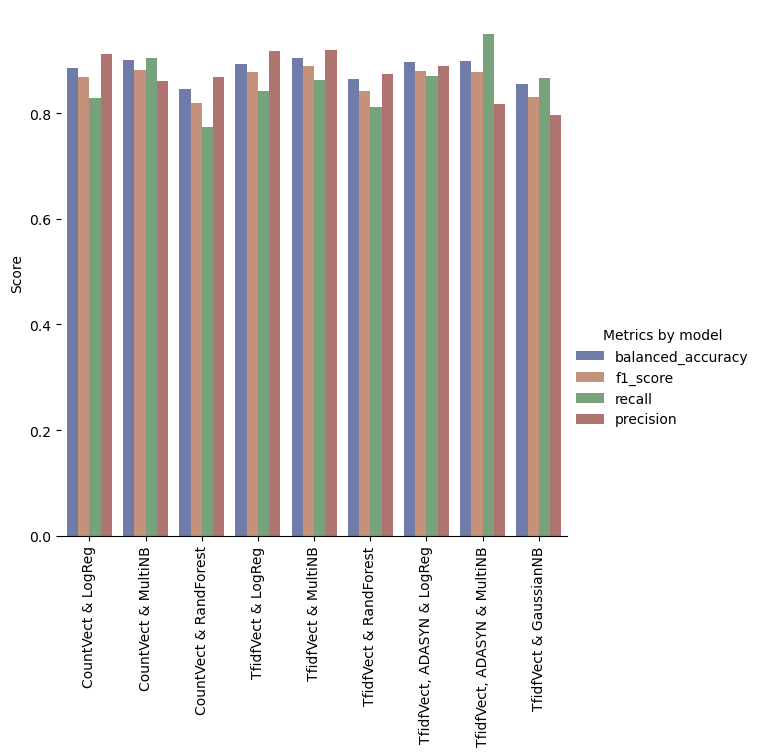

In [26]:
bars = sns.catplot(
    data=scores_df, kind="bar",
    x="model_name", y="score", hue="score_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("", "Score")
plt.xticks(rotation=90)
bars.legend.set_title("Metrics by model");

In [206]:
scores_df.loc[scores_df["score_type"] == "balanced_accuracy"]

,model_name,score_type,score
0,CountVect & LogReg,balanced_accuracy,0.886560
0,CountVect & MultiNB,balanced_accuracy,0.900461
0,CountVect & RandForest,balanced_accuracy,0.865560
0,TfidfVect & LogReg,balanced_accuracy,0.894285
0,TfidfVect & MultiNB,balanced_accuracy,0.904701
0,TfidfVect & RandForest,balanced_accuracy,0.855494
0,"TfidfVect, ADASYN & LogReg",balanced_accuracy,0.897069
0,"TfidfVect, ADASYN & MultiNB",balanced_accuracy,0.899779
0,TfidfVect & GaussianNB,balanced_accuracy,0.855162


----

# Analysis
- focusing on the best performing model

In [42]:
# found this on stack overflow: https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby
highest_scores = scores_df.groupby("score_type")["score"].max()
print(f"model with best balanced accuracy score: {scores_df.loc[(scores_df['score_type'] == 'balanced_accuracy') & (scores_df['score'] == highest_scores['balanced_accuracy'])]['model_name']}")
print(f"model with best f1 score: {scores_df.loc[(scores_df['score_type'] == 'f1_score') & (scores_df['score'] == highest_scores['f1_score'])]['model_name']}")
print(f"model with best recall score: {scores_df.loc[(scores_df['score_type'] == 'recall') & (scores_df['score'] == highest_scores['recall'])]['model_name']}")
print(f"model with best precision score: {scores_df.loc[(scores_df['score_type'] == 'precision') & (scores_df['score'] == highest_scores['precision'])]['model_name']}");

model with best balanced accuracy score: 0    TfidfVect & MultiNB
Name: model_name, dtype: object
model with best f1 score: 1    TfidfVect & MultiNB
Name: model_name, dtype: object
model with best recall score: 2    TfidfVect, ADASYN & MultiNB
Name: model_name, dtype: object
model with best precision score: 3    TfidfVect & MultiNB
Name: model_name, dtype: object


In [48]:
highest_scores

score_type
balanced_accuracy    0.904701
f1_score             0.890323
precision            0.920000
recall               0.950000
Name: score, dtype: float64

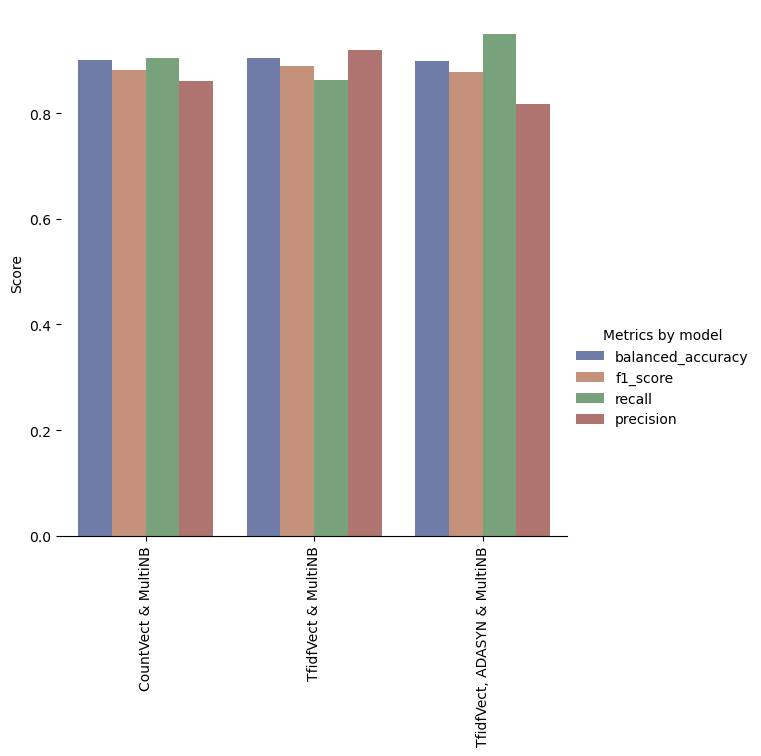

In [47]:
best_models = scores_df.loc[scores_df["model_name"].str.contains("MultiNB")]

bars = sns.catplot(
    data=best_models, kind="bar",
    x="model_name", y="score", hue="score_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("", "Score")
plt.xticks(rotation=90)
bars.legend.set_title("Metrics by model");

In [180]:
scores_df.loc[scores_df["model_name"] == "TfidfVect & MultiNB"]

,model_name,score_type,score
0,TfidfVect & MultiNB,balanced_accuracy,0.904701
1,TfidfVect & MultiNB,f1_score,0.890323
2,TfidfVect & MultiNB,recall,0.862500
3,TfidfVect & MultiNB,precision,0.920000


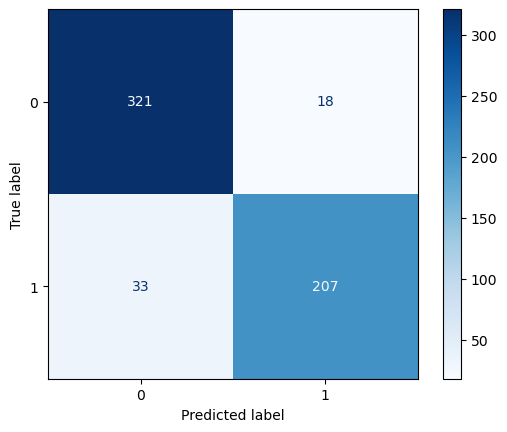

In [80]:
ConfusionMatrixDisplay.from_estimator(gs_5, X_test, y_test, cmap='Blues');

roc_auc_score: 0.9047013274336283
balanced_accuracy_score: 0.9047013274336284
f_1 score: 0.8903225806451613


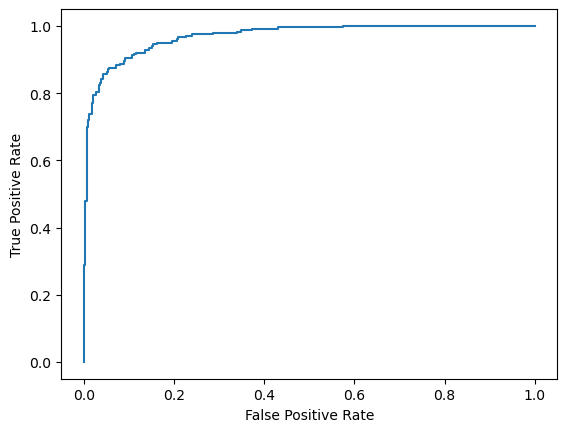

In [74]:
preds = gs_5.predict(X_test)
print(f"roc_auc_score: {roc_auc_score(y_test, preds)}")
print(f"balanced_accuracy_score: {balanced_accuracy_score(y_test, preds)}")
print(f"f_1 score: {f1_score(y_test, preds)}")

# got this from: https://www.statology.org/plot-roc-curve-python/
#define metrics
y_pred_proba = gs_5.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [136]:
y_with_index = pd.DataFrame(y_test)
y_with_index["index"] = y_with_index.index
y_with_index["preds"] = preds
y_with_index.head()

,target,index,preds
1122,0,1122,0
1371,0,1371,0
1551,0,1551,0
1650,0,1650,0
854,0,854,0


In [137]:
incorrect_preds = y_with_index.loc[y_with_index["target"] != y_with_index["preds"]]
print(incorrect_preds.shape)
incorrect_preds.head()

(51, 3)


,target,index,preds
577,0,577,1
402,0,402,1
2028,1,2028,0
288,0,288,1
2846,1,2846,0


In [99]:
pos_class_vocab = pd.read_csv("data/pos_class_vocab.csv")
neg_class_vocab = pd.read_csv("data/neg_class_vocab.csv")

In [138]:
pos_word_set = set(pos_class_vocab["word"])
neg_word_set = set(neg_class_vocab["word"])

In [162]:
def examine_errors(errors, posts, pos_word_set, neg_word_set):
    details =[]
    for error in errors["index"]:
        error_dict = {}
        words = set(re.findall(r"(?u)\b\w\w+\b", " ".join(posts.iloc[error]["selftext"].split())))
        error_dict["index"] = error
        error_dict["in_pos_vocab"] = len(words.intersection(pos_word_set))
        error_dict["in_neg_vocab"] = len(words.intersection(neg_word_set))
        error_dict["not_in_pos"] = len(words.difference(pos_word_set))
        error_dict["not_in_neg"] = len(words.difference(neg_word_set))
        error_dict["subreddit"] = posts.iloc[error]["subreddit"]
        # error_dict["error_type"] = errors.loc[errors["index"] == [error]]["preds"]
        details.append(error_dict)
    return pd.DataFrame.from_dict(details)  
        

In [163]:
error_df = examine_errors(incorrect_preds, posts, pos_word_set, neg_word_set)

In [164]:
error_df["error_type"] = np.where(incorrect_preds["preds"] == 1, "false positive", "false negative")

In [165]:
error_df.head()

,index,in_pos_vocab,in_neg_vocab,not_in_pos,not_in_neg,subreddit,error_type
0,577,13,9,49,53,askscience,false positive
1,402,0,0,7,7,askscience,false positive
2,2028,3,3,22,22,AskScienceFiction,false negative
3,288,7,4,22,25,askscience,false positive
4,2846,0,1,15,14,AskScienceFiction,false negative


In [167]:
error_df["subreddit"].value_counts(normalize=True)

subreddit
AskScienceFiction    0.647059
askscience           0.313725
space                0.039216
Name: proportion, dtype: float64

In [168]:
posts["subreddit"].value_counts(normalize=True)

subreddit
AskScienceFiction    0.414044
space                0.331027
askscience           0.254929
Name: proportion, dtype: float64

In [170]:
error_df["proportion_unmatched"] = (error_df["not_in_neg"] + error_df["not_in_pos"]) / (error_df["in_pos_vocab"] + error_df["in_neg_vocab"] + error_df["not_in_neg"] + error_df["not_in_pos"])
error_df["proportion_matched"] = (error_df["in_neg_vocab"] + error_df["in_pos_vocab"]) / (error_df["in_pos_vocab"] + error_df["in_neg_vocab"] + error_df["not_in_neg"] + error_df["not_in_pos"])

In [171]:
error_df.head()

,index,in_pos_vocab,in_neg_vocab,not_in_pos,not_in_neg,subreddit,error_type,proportion_unmatched,proportion_matched
0,577,13,9,49,53,askscience,false positive,0.822581,0.177419
1,402,0,0,7,7,askscience,false positive,1.000000,0.000000
2,2028,3,3,22,22,AskScienceFiction,false negative,0.880000,0.120000
3,288,7,4,22,25,askscience,false positive,0.810345,0.189655
4,2846,0,1,15,14,AskScienceFiction,false negative,0.966667,0.033333


In [172]:
fp_df = error_df.loc[error_df["error_type"] == "false positive"]
fn_df = error_df.loc[error_df["error_type"] == "false negative"]

In [208]:
fp_df["subreddit"].value_counts(normalize=True)

subreddit
askscience    0.888889
space         0.111111
Name: proportion, dtype: float64

In [178]:
error_details = [
    {"error": "false positive",
     "proportion_type": "not in vectorized data",
     "mean": error_df.loc[error_df["error_type"] == "false positive"]["proportion_unmatched"].mean()
    },
    {
     "error": "false positive",
     "proportion_type": "in vectorized data",
     "mean": error_df.loc[error_df["error_type"] == "false positive"]["proportion_matched"].mean(),
     },
     {"error": "false negative",
     "proportion_type": "not in vectorized data",
     "mean": error_df.loc[error_df["error_type"] == "false negative"]["proportion_unmatched"].mean()
    },
    {
     "error": "false negative",
     "proportion_type": "in vectorized data",
     "mean": error_df.loc[error_df["error_type"] == "false negative"]["proportion_matched"].mean(),
     }
]

details_df = pd.DataFrame.from_dict(error_details)
details_df.head()

,error,proportion_type,mean
0,false positive,not in vectorized data,0.894308
1,false positive,in vectorized data,0.105692
2,false negative,not in vectorized data,0.873038
3,false negative,in vectorized data,0.126962


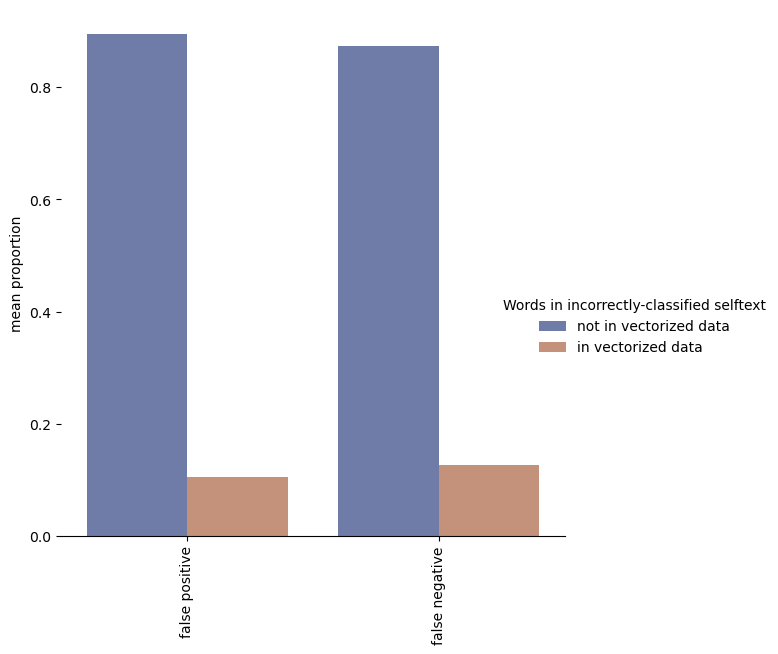

In [179]:
bars = sns.catplot(
    data=details_df, kind="bar",
    x="error", y="mean", hue="proportion_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("", "mean proportion")
plt.xticks(rotation=90)
bars.legend.set_title("Words in incorrectly-classified selftext");

In [209]:
correct_preds = y_with_index.loc[y_with_index["target"] == y_with_index["preds"]]
accurate_df = examine_errors(correct_preds, posts, pos_word_set, neg_word_set)
accurate_df["type"] = np.where(correct_preds["preds"] == 1, "true positive", "true negative")

accurate_df["proportion_unmatched"] = (accurate_df["not_in_neg"] + accurate_df["not_in_pos"]) / (accurate_df["in_pos_vocab"] + accurate_df["in_neg_vocab"] + accurate_df["not_in_neg"] + accurate_df["not_in_pos"])
accurate_df["proportion_matched"] = (accurate_df["in_neg_vocab"] + accurate_df["in_pos_vocab"]) / (accurate_df["in_pos_vocab"] + accurate_df["in_neg_vocab"] + accurate_df["not_in_neg"] + accurate_df["not_in_pos"])

accurate_details = [
    {"label": "true positive",
     "proportion_type": "not in vectorized data",
     "mean": accurate_df.loc[accurate_df["type"] == "true positive"]["proportion_unmatched"].mean()
    },
    {
     "label": "true positive",
     "proportion_type": "in vectorized data",
     "mean": accurate_df.loc[accurate_df["type"] == "true positive"]["proportion_matched"].mean(),
     },
     {"label": "true negative",
     "proportion_type": "not in vectorized data",
     "mean": accurate_df.loc[accurate_df["type"] == "true negative"]["proportion_unmatched"].mean()
    },
    {
     "label": "true negative",
     "proportion_type": "in vectorized data",
     "mean": accurate_df.loc[accurate_df["type"] == "true negative"]["proportion_matched"].mean(),
     }
]

acc_details_df = pd.DataFrame.from_dict(accurate_details)
acc_details_df.head()

,label,proportion_type,mean
0,true positive,not in vectorized data,0.874811
1,true positive,in vectorized data,0.125189
2,true negative,not in vectorized data,0.880422
3,true negative,in vectorized data,0.119578


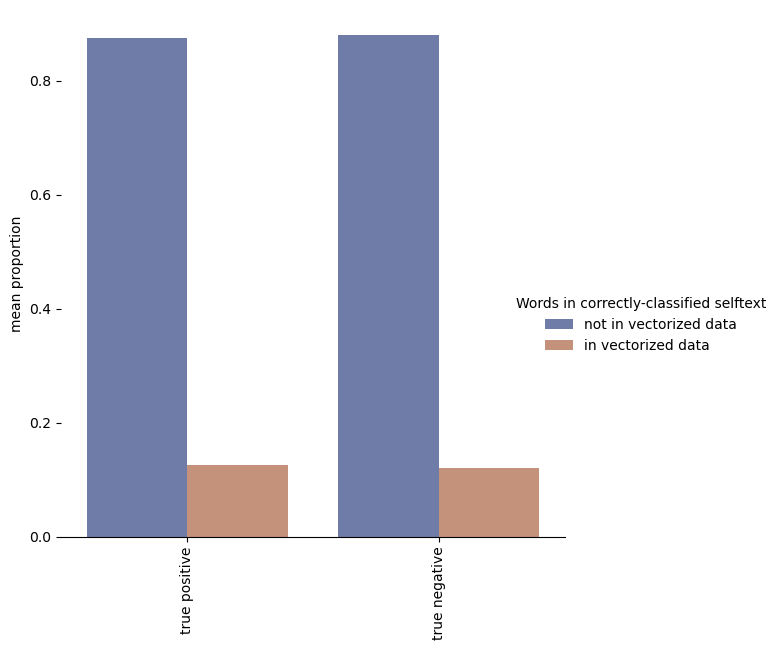

In [211]:
bars = sns.catplot(
    data=acc_details_df, kind="bar",
    x="label", y="mean", hue="proportion_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
bars.despine(left=True)
bars.set_axis_labels("", "mean proportion")
plt.xticks(rotation=90)
bars.legend.set_title("Words in correctly-classified selftext");

### Closer look at some specific errors

In [189]:
posts.iloc[402]["selftext"]

'My daughter asks, do ladybugs have uteruses?'

In [200]:
sample_402_words = re.findall(r"(?u)\b\w\w+\b", " ".join(posts.iloc[402]["selftext"].split()))
sample_402_in_pos = set(sample_402_words).intersection(set(pos_class_vocab["word"]))
sample_402_in_neg = set(sample_402_words).intersection(set(neg_class_vocab["word"]))
print(f"number of words in positive vocab: {len(sample_402_in_pos)}; in negative: {len(sample_402_in_neg)}")
sample_402_not_in_pos = set(sample_402_words).difference(set(pos_class_vocab["word"]))
sample_402_not_in_neg = set(sample_402_words).difference(set(neg_class_vocab["word"]))
print(f"number not in positive vocab: {len(sample_402_not_in_pos)}; not in negative: {len(sample_402_not_in_neg)}")
print(f"predicted class: {incorrect_preds.loc[incorrect_preds['index'] == 402]['preds']}")

number of words in positive vocab: 0; in negative: 0
number not in positive vocab: 7; not in negative: 7
predicted class: 402    1
Name: preds, dtype: int64


In [203]:
posts.iloc[402]["subreddit"]

'askscience'

- index 577

In [182]:
posts.iloc[577]["selftext"]

'So when a person gets for example a complete hand from a donor, i would assume the DNA of that hand is from the donor.\n\nThen again they every part of a person get replaced in about 15 years(i.e. nails growing, skin shedding etc). So what will happen with the DNA already in the donated hand. Will this get replaced, or would it stay the same.\nAnd how would for example a crime scene look after the person with the new hand commits a crime, would the police know about the added DNA? Sure they will find 2 DNAs, but how does that work?'

In [202]:
sample_577_words = re.findall(r"(?u)\b\w\w+\b", " ".join(posts.iloc[577]["selftext"].split()))
sample_577_in_pos = set(sample_577_words).intersection(set(pos_class_vocab["word"]))
sample_577_in_neg = set(sample_577_words).intersection(set(neg_class_vocab["word"]))
print(f"number of words in positive vocab: {len(sample_577_in_pos)}; in negative: {len(sample_577_in_neg)}")
sample_577_not_in_pos = set(sample_577_words).difference(set(pos_class_vocab["word"]))
sample_577_not_in_neg = set(sample_577_words).difference(set(neg_class_vocab["word"]))
print(f"number not in positive vocab: {len(sample_577_not_in_pos)}; not in negative: {len(sample_577_not_in_neg)}")
print(f"predicted class: {incorrect_preds.loc[incorrect_preds['index'] == 577]['preds']}")

number of words in positive vocab: 13; in negative: 9
number not in positive vocab: 49; not in negative: 53
predicted class: 577    1
Name: preds, dtype: int64


In [215]:
sample_577_in_pos

{'assume',
 'crime',
 'example',
 'gets',
 'hand',
 'happen',
 'look',
 'new',
 'person',
 'police',
 'scene',
 'work',
 'years'}

In [216]:
sample_577_not_in_pos

{'15',
 'And',
 'DNA',
 'DNAs',
 'So',
 'Sure',
 'Then',
 'Will',
 'about',
 'added',
 'after',
 'again',
 'already',
 'but',
 'commits',
 'complete',
 'does',
 'donated',
 'donor',
 'etc',
 'every',
 'find',
 'for',
 'from',
 'get',
 'growing',
 'how',
 'in',
 'is',
 'it',
 'know',
 'nails',
 'of',
 'or',
 'part',
 'replaced',
 'same',
 'shedding',
 'skin',
 'stay',
 'that',
 'the',
 'they',
 'this',
 'what',
 'when',
 'will',
 'with',
 'would'}

In [108]:
posts.iloc[577]["subreddit"]

'askscience'

- index 2028

In [183]:
posts.iloc[2028]["selftext"]

'[Discworld] How does the day/night cycle work? Does the Great A’Tuin spin as they fly through space, exposing the top of the disc to sunlight, darkness, sunlight, darkness, etc?'

In [204]:
sample_2028_words = re.findall(r"(?u)\b\w\w+\b", " ".join(posts.iloc[2028]["selftext"].split()))
sample_2028_in_pos = set(sample_2028_words).intersection(set(pos_class_vocab["word"]))
sample_2028_in_neg = set(sample_2028_words).intersection(set(neg_class_vocab["word"]))
print(f"number of words in positive vocab: {len(sample_2028_in_pos)}; in negative: {len(sample_2028_in_neg)}")
sample_2028_not_in_pos = set(sample_2028_words).difference(set(pos_class_vocab["word"]))
sample_2028_not_in_neg = set(sample_2028_words).difference(set(neg_class_vocab["word"]))
print(f"number not in positive vocab: {len(sample_2028_not_in_pos)}; not in negative: {len(sample_2028_not_in_neg)}")
print(f"predicted class: {incorrect_preds.loc[incorrect_preds['index'] == 2028]['preds']}")

number of words in positive vocab: 3; in negative: 3
number not in positive vocab: 22; not in negative: 22
predicted class: 2028    0
Name: preds, dtype: int64


In [205]:
posts.iloc[2028]["subreddit"]

'AskScienceFiction'